In [1]:
import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier


In [2]:
def entropy(y):
    """Вычисляет энтропию множества классов y"""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))


def information_gain(x, y, feature_index):
    """Вычисляет Information Gain для признака"""
    total_entropy = entropy(y)
    values, counts = np.unique(x[:, feature_index], return_counts=True)
    weighted_entropy = np.sum([
        (counts[i] / len(y)) * entropy(y[x[:, feature_index] == values[i]])
        for i in range(len(values))
    ])
    return total_entropy - weighted_entropy


def split_information(x, feature_index):
    """Вычисляет Split Information (штраф за разбиение)"""
    values, counts = np.unique(x[:, feature_index], return_counts=True)
    probs = counts / len(x)
    return -np.sum(probs * np.log2(probs))


def gain_ratio(x, y, feature_index):
    """Вычисляет Gain Ratio"""
    ig = information_gain(x, y, feature_index)
    si = split_information(x, feature_index)
    return ig / si if si != 0 else 0


def calculate_gain_ratio(data, x, y) -> dict:
    res = {}
    feature_names = data.columns
    for i, feature in enumerate(feature_names):
        gr = gain_ratio(x, y, i)
        res[feature] = gr
    return res

In [3]:
def correl(df_in, threshold):
    df_corr = df_in.corr().abs()
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    tri_df = df_corr.mask(mask)
    seaborn.heatmap(tri_df, cmap="coolwarm", annot=True)
    plt.show()
    to_drop = [c for c in tri_df.columns if any(tri_df[c] > threshold)]
    reduced_df = df_in.drop(to_drop, axis=1)
    print(f'dropped: {to_drop}')
    return reduced_df


def fill_missing_values(dataset):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(dataset)
    imp.transform(dataset)

In [4]:
def preprocess_dataset(dataset) -> pd.DataFrame:
    dataset = dataset.copy()
    fill_missing_values(dataset)
    dataset = correl(dataset, 0.6)
    return dataset

In [5]:
def process_decision_tree(dataset):
    dataset = dataset.copy()
    y = dataset.pop("quality").values
    dataset = preprocess_dataset(dataset)
    x = dataset.values
    clf = DecisionTreeClassifier(criterion="entropy")
    clf.fit(x, y)

    importances = clf.feature_importances_
    res = {}
    for i, c in enumerate(dataset.columns):
        res[c] = importances[i]
    return res

In [6]:
def process_gain_ratio(dataset):
    dataset = dataset.copy()
    y = dataset.pop("quality").values
    dataset = preprocess_dataset(dataset)
    for c in dataset.columns:
        dataset[c] = pd.cut(dataset[c], bins=2, labels=[0, 1])

    x = dataset.values
    res = calculate_gain_ratio(dataset, x, y)
    return res

In [7]:
def convert_to_dataframe(data: dict) -> pd.DataFrame:
    l = [(v, k) for k, v in data.items()]
    l.sort(reverse=True)
    names = [i[1] for i in l]
    values = [i[0] for i in l]
    df = pd.DataFrame(names, columns=['feature_name'])
    df['value'] = values
    return df

In [8]:
dataset_white = pd.read_csv("data/winequality-white.csv", delimiter=";")
dataset_red = pd.read_csv("data/winequality-red.csv", delimiter=";")
dataset_white["type"] = 0
dataset_red["type"] = 1
total = pd.concat([dataset_white, dataset_red])

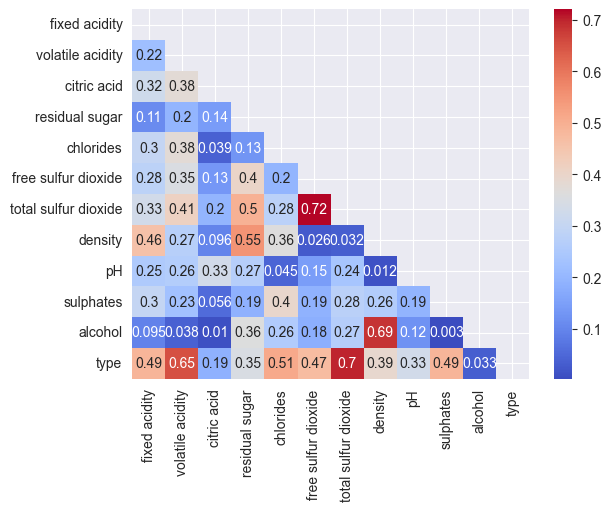

dropped: ['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'density']


,feature_name,value
0,alcohol,0.162742
1,residual sugar,0.084778
2,citric acid,0.060849
3,chlorides,0.040068
4,sulphates,0.030077
5,type,0.016718
6,fixed acidity,0.004109
7,pH,0.002857


In [9]:
convert_to_dataframe(process_gain_ratio(total))

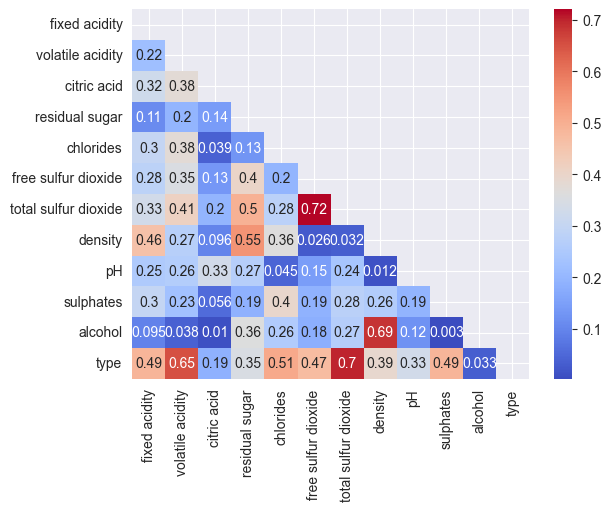

dropped: ['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'density']


,feature_name,value
0,alcohol,0.194523
1,residual sugar,0.147210
2,sulphates,0.137942
3,citric acid,0.132527
4,pH,0.130771
5,fixed acidity,0.129586
6,chlorides,0.121784
7,type,0.005657


In [10]:
convert_to_dataframe(process_decision_tree(total))